In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.datasets import mnist
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [3]:
(X_Train,_),(_,_) = mnist.load_data()

In [4]:
print(X_Train.shape)

(60000, 28, 28)


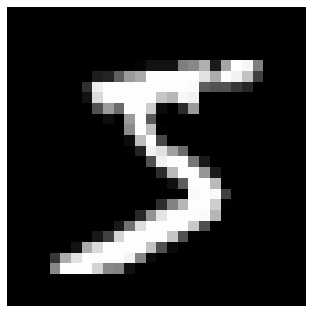

In [5]:
# Visualize
plt.style.use('seaborn')
plt.axis('off')
plt.imshow(X_Train[0],cmap='gray')
plt.show()

In [6]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*X_Train.shape,1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [7]:
# Normalize this data - [-1,1]
#print(X_Train[0]) - btw 0-255 (int)

X_Train = (X_Train.astype('float32') - 127.5) / 127.5

print(np.min(X_Train))
print(np.max(X_Train))


-1.0
1.0


In [8]:
TOTAL_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_Train.shape[0]/BATCH_SIZE) # 60000/256
HALF_BATCH = 128
NOISE_DIM = 100 # Upsample into 784 dim vector
adam = Adam(lr=2e-4,beta_1=0.5)

In [9]:
# Define the Generator
generator = Sequential()

generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double Activation Size - 14 x 14 x 64
generator.add(Conv2DTranspose(64,kernel_size=(5,5),strides=(2,2),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double Activation Size - 28 x 28 x 1
generator.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same',activation='tanh'))

generator.compile(loss='binary_crossentropy',optimizer=adam)
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________

In [10]:
# Define the Discriminator Model
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Next Conv Layer 14 x 14 x 64 ---> 7 x 7 x 128
discriminator.add(Conv2D(128,kernel_size=(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))

# Flatten
discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [11]:
# GAN 
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [12]:
import os
#os.mkdir('model')
#os.mkdir('images')
os.listdir()

['.ipynb_checkpoints',
 'content',
 'images',
 'images.zip',
 'MNIST_DC_GAN-Conv2DTranspose.ipynb',
 'MNIST_DC_GAN.ipynb',
 'model']

In [13]:
def save_images(epoch,samples=100):

  noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
  generated_imgs = generator.predict(noise)
  generated_imgs = generated_imgs.reshape(samples,28,28)

  plt.figure(figsize=(10,10))

  for i in range(samples):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.savefig('images/gan_output_epoch_{}.png'.format(epoch+1))
  plt.show()

In [ ]:
# Training Loop

d_losses = []
g_losses = []

for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss = 0.
  epoch_g_loss = 0.

  # Mini batch SGD
  for step in range(NO_OF_BATCHES):

    # Step-3 Discriminator Training, generator frozen
    # 50% Real Data + 50% Fake Data

    # Real Data X
    idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH)
    real_imgs = X_Train[idx]

    # Fake Data X
    noise = np.random.normal(0,1,size=(HALF_BATCH,NOISE_DIM))
    fake_imgs = generator.predict(noise) # Forward Pass only, no training - updating wts of generator

    # Labels
    real_y = np.ones((HALF_BATCH,1)) * 0.9
    fake_y = np.zeros((HALF_BATCH,1))

    # Train our Discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
    d_loss = 0.5*d_loss_real + 0.5*d_loss_fake

    epoch_d_loss += d_loss

    # Train Generator (Considering Frozen Discriminator)
    noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    ground_truth_y = np.ones((BATCH_SIZE,1))
    g_loss = model.train_on_batch(noise,ground_truth_y)
    epoch_g_loss += g_loss

  print("Epoch= %d , Discriminator Loss= %.4f, Generator Loss= %.4f"%((epoch+1),epoch_d_loss/NO_OF_BATCHES, epoch_g_loss/NO_OF_BATCHES))
  d_losses.append(epoch_d_loss/NO_OF_BATCHES)
  g_losses.append(epoch_g_loss/NO_OF_BATCHES)

  if (epoch+1)%5==0:
    generator.save('model/mnist_gan_generator_{}.h5'.format(epoch+1))
    save_images(epoch)

In [ ]:
!zip -r /content/images.zip /content/images 

In [ ]:
from google.colab import files
files.download('images.zip')

In [ ]:
plt.plot(d_losses,label="Disc")
plt.plot(g_losses,label="Gen")
plt.legend()
plt.show()


In [ ]:
model = Sequential()
model.add(Dense(100,input_shape=(25,10)))
model.add(LeakyReLU(0.2))
model.add(BatchNormalization())
model.summary()

In [ ]:
Dense?